In [1]:
from scipy.integrate import solve_bvp, trapezoid, solve_ivp
import numpy as np
from ipydex import IPS, activate_ips_on_exception
import matplotlib.pyplot as plt

activate_ips_on_exception()

In [2]:
t0 = 0
tend = 1.8
N = 6

b1 = np.array([0, 0.4*np.pi, 0, 0])
b2 = np.array([0.3*np.pi, 0.2*np.pi, 0, 0])

In [27]:
def theta(t, k):
    return np.abs(t-k/(N+1)*tend)**3

def spline(t, k):
    # interval length
    l = (tend-t0) / N
    if k*l <= t and t <= (k+1)*l:
        return np.abs(t-(k+0.5)*l)**3
    else:
        return 0

def Theta(t, k):
    t = np.linspace(0, t, num=50)
    y = theta(t, k)
    return trapezoid(y, t)

def TTheta(t, k):
    t = np.linspace(0, t, num=50)
    y = Theta(t, k)
    return trapezoid(y, t)

theta_0 = np.array([theta(0, i) for i in range(6)])
theta_tend = np.array([theta(tend, i) for i in range(6)])
Theta_tend = np.array([Theta(tend, i) for i in range(6)])
TTheta_tend = np.array([TTheta(tend, i) for i in range(6)])

A = np.array([theta_0[2:],
              theta_tend[2:],
              Theta_tend[2:],
              TTheta_tend[2:]])

B = np.array([0,0,0,b2[0]])
C = np.array([theta_0[:2],
              theta_tend[:2],
              Theta_tend[:2],
              TTheta_tend[:2]])

def get_full_a(a1, a2, all=False):
    a_rest = np.linalg.inv(A) @ (B - C @ np.array([a1, a2]))
    if all:
        return np.concatenate((np.array([a1,a2]), a_rest))
    else:
        return a_rest

def get_v(t, p):
    v = 0
    method = 2
    if method == 1:
        for k in range(N):
            v += p[k] * theta(t, k)
    elif method == 2:
        # polynomial
        for k in range(N):
            v += p[k] * t**k
    elif method == 3:
        v += p[k] * spline(t, k)
    return v

In [28]:
def rhs(t, x, p):
    eta = 0.9

    phi1, phi2, omega1, omega2 = x
    # x1... phi1, angle at active joint
    # x2... phi2, angle at passive joint
    # x3... omega1, velocity of first arm
    # x4... omega2, velocity of second arm

    # a = get_full_a(p[0], p[1], all=True)
    # v = get_v(t, a)
    v = get_v(t, p)


    dxdt1 = omega1
    dxdt2 = omega2
    dxdt3 = v
    dxdt4 = -v * (1 + eta*np.cos(phi2)) - eta*omega1**2*np.sin(phi2)
    return np.array([dxdt1, dxdt2, dxdt3, dxdt4])

In [5]:
# def bc(xa, xb, p):
#     a = get_full_a(p[0], p[1], all=True)
#     return np.concatenate((xa-b1, xb-b2, np.array([get_v(0, a), get_v(tend, a)])))
def bc(xa, xb, p):
    return np.concatenate((xa-b1, xb-b2, np.array([get_v(0, p), get_v(tend, p)])))

In [6]:
"""
we need 6 parameters to get n+k=4+6=10 bc
but only 2 of those 6 are actually relevant, the rest dont matter
-> first 2 are used to calculate a3-a6
"""
t = np.linspace(t0, tend, 50)
x0 = np.ones((4, t.size))
x0[0] = b1[0]
x0[1] = b1[1]
x0[2] = b1[2]
x0[3] = b1[3]

In [7]:
res = solve_bvp(rhs, bc, t, x0, p=1*np.ones(N), verbose=2)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          3.85e-02       1.77e-06          50             24       
       2          2.58e-03       1.25e-09          74              3       
       3          9.64e-04       3.64e-12          77              0       
Solved in 3 iterations, number of nodes 77. 
Maximum relative residual: 9.64e-04 
Maximum boundary residual: 3.64e-12


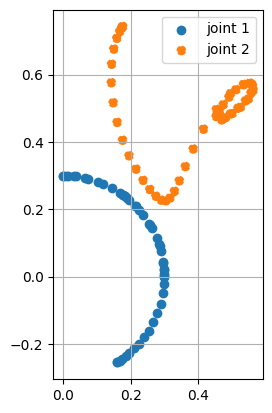

In [8]:
# cartesian coordinates
l1 = 0.3
l2 = 0.5
x_inner = l1 * np.cos(res.sol(t)[0])
y_inner = l1 * np.sin(res.sol(t)[0])

x_outer = x_inner + l2 * np.cos(res.sol(t)[0] + res.sol(t)[1])
y_outer = y_inner + l2 * np.sin(res.sol(t)[0] + res.sol(t)[1])

plt.scatter(x_inner, y_inner, label="joint 1")
plt.scatter(x_outer, y_outer, label="joint 2", linestyle="dashed")
plt.legend()
plt.gca().set_aspect('equal')
plt.grid()


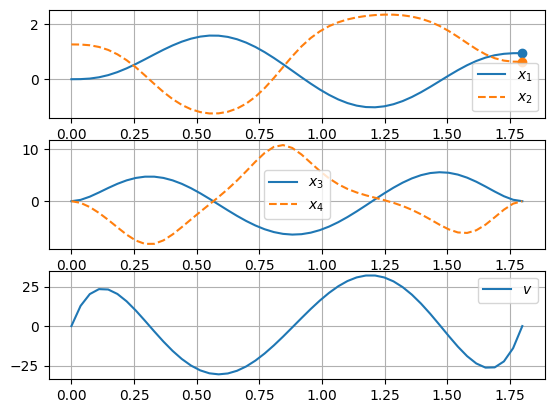

In [9]:
# plot state components
fig, ax = plt.subplots(3,1)
ax[0].plot(t, res.sol(t)[0], label=f"$x_{1}$", color="tab:blue")
ax[0].scatter(t[-1], b2[0], color="tab:blue")
ax[0].plot(t, res.sol(t)[1], label=f"$x_{2}$", linestyle="dashed", color="tab:orange")
ax[0].scatter(t[-1], b2[1], color="tab:orange")
ax[0].legend()
ax[0].grid()

ax[1].plot(t, res.sol(t)[2], label=f"$x_{3}$")
ax[1].plot(t, res.sol(t)[3], label=f"$x_{4}$", linestyle="dashed")
ax[1].legend()
ax[1].grid()

ax[2].plot(t, get_v(t, res.p), label=f"$v$")
ax[2].legend()
ax[2].grid()

In [30]:
# Probe
x0_test = b1 + np.array([0,0.1,0,0])
sol = solve_ivp(rhs, (t0, tend), x0_test, t_eval=np.linspace(t0, tend, 110), args=[res.p])
sol

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.651e-02 ...  1.783e+00  1.800e+00]
        y: [[ 0.000e+00  3.088e-04 ...  9.422e-01  9.425e-01]
            [ 1.357e+00  1.356e+00 ...  2.513e+00  2.501e+00]
            [ 0.000e+00  5.520e-02 ...  6.006e-02 -2.622e-05]
            [ 0.000e+00 -6.578e-02 ... -7.231e-01 -7.066e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 116
     njev: 0
      nlu: 0

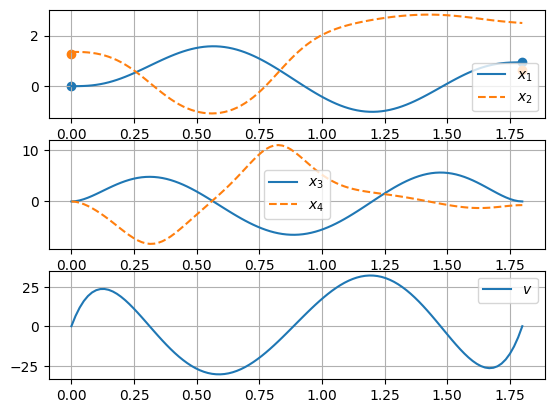

In [31]:
# plot state components
fig, ax = plt.subplots(3,1)
ax[0].plot(sol.t, sol.y[0], label=f"$x_{1}$", color="tab:blue")
ax[0].scatter(sol.t[-1], b2[0], color="tab:blue")
ax[0].scatter(sol.t[0], b1[0], color="tab:blue")
ax[0].plot(sol.t, sol.y[1], label=f"$x_{2}$", linestyle="dashed", color="tab:orange")
ax[0].scatter(sol.t[-1], b2[1], color="tab:orange")
ax[0].scatter(sol.t[0], b1[1], color="tab:orange")
ax[0].legend()
ax[0].grid()

ax[1].plot(sol.t, sol.y[2], label=f"$x_{3}$")
ax[1].plot(sol.t, sol.y[3], label=f"$x_{4}$", linestyle="dashed")
ax[1].legend()
ax[1].grid()

ax[2].plot(sol.t, get_v(sol.t, res.p), label=f"$v$")
ax[2].legend()
ax[2].grid()


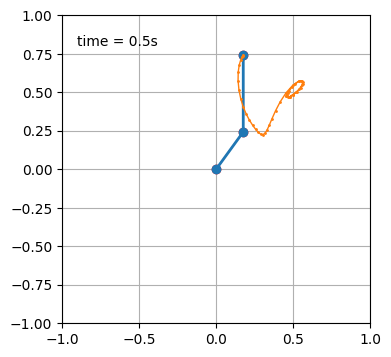

In [28]:
if 0:
    import matplotlib.animation as animation
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(autoscale_on=False, xlim=(-1, 1), ylim=(-1, 1.))
    ax.set_aspect('equal')
    ax.grid()

    # c1 = plt.Circle((0,0), l1, fill=False)
    # c2 = plt.Circle((0,l1), l2, fill=False)
    # ax.add_patch(c1)
    # ax.add_patch(c2)

    ax.plot(
        [0, l1*np.cos(b2[0]), l1*np.cos(b2[0]) + l2*np.cos(b2[0]+b2[1])],
        [0, l1*np.sin(b2[0]), l1*np.sin(b2[0]) + l2*np.sin(b2[0]+b2[1])],
        'o-', lw=1, color="red")

    line, = ax.plot([], [], 'o-', lw=2)
    trace, = ax.plot([], [], '.-', lw=1, ms=2)
    time_template = 'time = %.1fs'
    time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
    dt = 0.01

    def animate(i):
        thisx = [0, x_inner[i], x_outer[i]]
        thisy = [0, y_inner[i], y_outer[i]]

        history_x = x_outer[:i]
        history_y = y_outer[:i]

        line.set_data(thisx, thisy)
        trace.set_data(history_x, history_y)
        time_text.set_text(time_template % (i*dt))

        # c2.set_center((x_inner[i], y_inner[i]))
        return line, trace, time_text#, c2
    y = np.empty((len(x_inner), 4))
    ani = animation.FuncAnimation(
        fig, animate, len(y), interval=dt*1000, blit=True)
    gif_writer = animation.ImageMagickWriter(fps=20)
    ani.save('anim_dip.gif', writer=gif_writer)